In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
!pip install vit_keras
!pip install -U tensorflow-addons
from vit_keras import vit
import tensorflow_datasets as tfds

!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=b7f701b29250505aed77461b3f29d43eb3acd52c75e5d992ec0c525febadad18
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 40.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteXX381O/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteXX381O/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteXX381O/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
img_size = 224
batch_size = 16
epochs = 40
learning_rate = 0.001
weight_decay = 0.0001
learning_rate = 1e-3

In [1]:
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (img_size, img_size))
  return  image, label

In [6]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

del raw_train
del raw_validation
del raw_test

In [7]:
train = train.unbatch().batch(batch_size,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(batch_size,drop_remainder=True).repeat()
# test = test.unbatch().batch(batch_size,drop_remainder=True).repeat()

In [8]:
steps_per_epoch = metadata.splits["train"].num_examples / batch_size 
validation_steps = metadata.splits["validation"].num_examples / batch_size

In [9]:
vit_model = vit.vit_b16(
        image_size = img_size,
        activation = 'gelu',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 102)

vit_model.summary()

347502902/347502902 [==============================] - 19s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [10]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(102)
])

In [11]:
def run_experiment(model):
  # optimizer = tfa.optimizers.AdamW(
  #   learning_rate=learning_rate, weight_decay=weight_decay
  # )

  # model.compile(
  #     optimizer=optimizer,
  #     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #     metrics=[
  #         tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
  #         tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  #     ],
  # )

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  hist = model.fit(
    x=train,
    epochs=3, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history
  
  model.load_weights(checkpoint_filepath)

  return hist


In [1]:
hist = run_experiment(model)

NameError: ignored

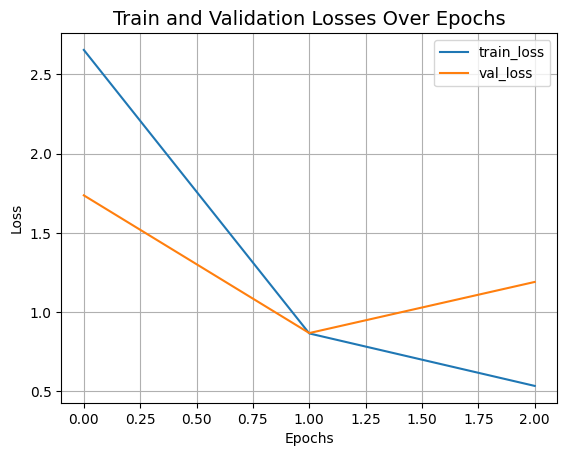

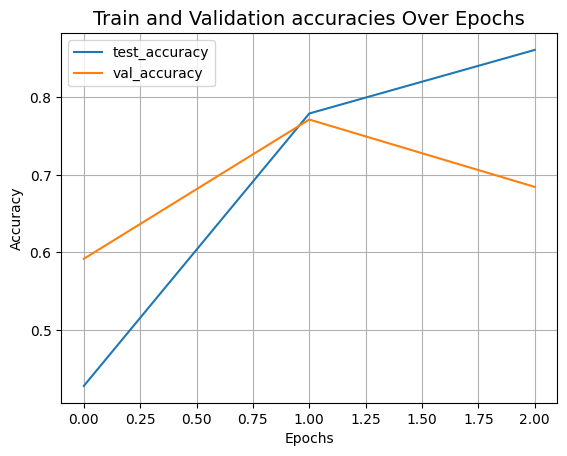

In [13]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [14]:
del train
# del validation
del hist

In [24]:
model.evaluate(test)

32/32 [==============================] - 15s 438ms/step - loss: 0.8636 - accuracy: 0.7510


[0.8636375069618225, 0.7509803771972656]

In [18]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

32/32 [==============================] - 17s 432ms/step


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.6774509803921569


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obtendo as previsões do modelo para o conjunto de teste
y_pred = predicted_classes

# Obtendo os rótulos verdadeiros do conjunto de teste
y_true = true_classes

# Calculando o recall ponderado
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Calculando a precisão ponderada
weighted_precision = precision_score(y_true, y_pred, average='weighted')

# Calculando o F1-score ponderado
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')

# Imprimindo os resultados
print("Weighted Recall:", weighted_recall)
print("Weighted Precision:", weighted_precision)
print("Weighted F1-Score:", weighted_f1_score)


Weighted Recall: 0.6774509803921569
Weighted Precision: 0.7931215654150283
Weighted F1-Score: 0.662910422800464


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
